<a href="https://colab.research.google.com/github/ricky-kiva/dl-deep-tf-cv-advanced/blob/main/1_l3_object_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Localization**

- We'll *classify* an image & *localize* by drawing bounding boxes around it

- We'll use MNIST dataset that is synthesized (modified) in terms of:

  - Placing each "digit" randomly on 75x75 blank canvas

- Note: the bounding box prediction can be modelled as *regression task*, means the model will predict a numeric value (as opposed to a category)

Import libraries

In [1]:
import os
import PIL
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

Define visualization parameters

In [2]:
im_width = 75
im_height = 75
normalized_coordinates = True

Function: Draw bounding boxes on image array

In [32]:
from PIL import ImageDraw

def draw_bounding_boxes_on_image_array(img, boxes, color=[], thickness=1, box_str_list=()):
  image_pil = PIL.Image.fromarray(img) # converts image (numpy) to PIL image object (to enable PIL manip.)

  # copy-paste to non-destructive editing
  # 'RGBA' add 'Alpha' channel
  rgbimg = PIL.Image.new("RGBA", image_pil.size) # create blank image with same size
  rgbimg.paste(image_pil) # paste original image to the blank image

  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, box_str_list)
  return np.array(rgbimg)

def draw_bounding_boxes_on_image(img, boxes, color=[], thickness=1, box_str_list=()):
  boxes_shape = boxes.shape
  if not boxes_shape: # check whether it's an empty array
    return

  # check if it has 'pred' & 'actual' bboxes
  # check if 'bboxes' has size of 4 (xmin, ymin, xmax, ymax)
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')

  # `boxes_shape` has `shape` of `(2, 4)`. It iterates over the bounding boxes (2)
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(img, boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2],
                               color[i], thickness, box_str_list[i])

def draw_bounding_box_on_image(img, ymin, xmin, ymax, xmax, color='red', thickness=1, display_str=None, normalized_coordinates=True):
  draw = PIL.ImageDraw.Draw(img) # create object that could draw on the image
  im_width, im_height = img.size # retrieves width & height of the image

  # calculate box coordinates
  if normalized_coordinates:
    (left, right, top, bottom) = ((xmin * im_width), (xmax * im_width),
                                  (ymin * im_height), (ymax * im_height))
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)

  # draw the bounding box
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)],
            width=thickness,
            fill=color)

Set *Matplotlib* config

In [4]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

Detect hardware for deciding *Distribution Strategies*

Note:
- If TPU is available, use TPU Strategy. Otherwise:
  - If `> 1` GPU is available, use Mirrored Strategy
  - If only `1` GPU / CPU is available, use Default Strategy

In [5]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

Select *Distribution Strategy*

In [6]:
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)

  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy()
  print('Running on single GPU', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

print('Number of accelerators:', strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators: 1


Define *Global Batch Size* parameter

Note:
- Global batch size will be shared across all replicas by *tf.data.Dataset API*
- Single TPU has 8 cores, means 8 replicas of the model will be distributed to each core
- Best practice is to scale the batch size by the number of replicas (*Learning rate* should be increased as well)

In [7]:
LOCAL_BATCH_SIZE = 64
GLOBAL_BATCH_SIZE = LOCAL_BATCH_SIZE * strategy.num_replicas_in_sync

TODO

In [8]:
# create_digits_from_local_fonts()
# plot_metrics()

Function: Transform each images by pasting it on 75x75 canvas at random location

In [9]:
def read_image_tfds(img, label):
  # get random integers from 'uniform distribution'
  # uniform distribution: (where every outcome has an equal chance of happening)
  # `()` in `shape` param. denotes a scalar / tensor with zero dimensions (essentially, single number)
  # params: (shape, minval, maxval, dtype)
  # `48` max padding got from "canvas - image_shape + 1 (0)" (75-28)
  xmin = tf.random.uniform((), 0, 48, dtype=tf.int32) # decide left padding
  ymin = tf.random.uniform((), 0, 48, dtype=tf.int32) # decide top padding
  img = tf.reshape(img, (28, 28, 1)) # reshape dataset image to shape (28,28) with single color channel

  # params: (image, offset_height, offset_width, target_height, target_width)
  img = tf.image.pad_to_bounding_box(img, ymin, xmin, 75, 75) # pad image with zeros to 'specified offset' until 'target dimension'
  img = tf.cast(img, tf.float32) / 255.0 # cast tensor to a float

  # find 'normalized' max & min coordinates (normalization makes it consistent regardless of the actual size of the canvas or image)
  xmax = (xmin + 28) / 75
  ymax = (ymin + 28) / 75
  xmin = xmin / 75
  ymin = ymin / 75

  # `one_hot` convert label as list where one element is "hot" (set to 1) & the rest are "cold" (set to 0)
  # - ex: tf.one_hot(3, 10) -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  return img, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])
# ...

Function: Get train dataset

In [10]:
import tensorflow_datasets as tfds

def get_train_dataset():
  # specify the operation inside this block will be distributed according to `strategy`
  with strategy.scope():
    # loads train MNIST dataset
    # `as_supervised`: dataset is returned in format (input, label) pairs
    # - Supervised Learning: train AI model in input-label manners
    # `try_gcs` will try to load dataset from Google Cloud Storage (GCS) if it's not available locally
    dataset = tfds.load('mnist', split='train', as_supervised=True, try_gcs=True)

    # applies function `read_image_tfds()` to each element in the dataset
    # `num_parallel_calls=16`: process up to 16 elements in parallel
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    # params: (buffer size, reshuffle_each_iteration)
    # `reshuffle_each_iteration`: if `.repeat()` executed, dataset will be shuffled again
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True) # take first '5000' data, put into buffer, & randomly shuffle the data

    # MANDATORY FOR KERAS
    # repeats indefinitely. ensure dataset doesn't run out of data when training
    dataset = dataset.repeat()

    # groups dataset elements into batches of size GLOBAL_BATCH_SIZE
    # `drop_remainder=True`: ensures all batches have same fixed size
    # - important for training using TPU
    dataset = dataset.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)

    # fetch (prepare) next batches while processing current batches
    # params: (buffer_size). `-1` allows Tensorflow to automatically tune prefetch 'buffer size'
    dataset = dataset.prefetch(-1)

    return dataset

Function: Get validation dataset

In [11]:
def get_validation_dataset():
  dataset = tfds.load('mnist', split='test', as_supervised=True, try_gcs=True)
  dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

  # why `batch()` first before `repeat()` in validation?
  # - `batch()` sets the size of each step of validation
  # - `repeat()` allows multiple epochs of validation without manual intervention
  dataset = dataset.batch(10000, drop_remainder=True)
  dataset = dataset.repeat() # MANDATORY FOR KERAS
  return dataset

Instantiate dataset

In [21]:
with strategy.scope():
  train_dataset = get_train_dataset()
  validation_dataset = get_validation_dataset()

Function: Pull some data from dataset with numpy format

In [22]:
# pull `N` data from dataset with numpy format
def dataset_to_numpy(train_dataset, validation_dataset, N):

  # Unbatch & re-batch train dataset, with a new batch size of `N`
  batch_train_ds = train_dataset.unbatch().batch(N)

  print(f"Executing eagerly: {tf.executing_eagerly()}")

  if tf.executing_eagerly():
    # (image, (one-hot-label, bboxes))
    for validation_img, (validation_labels, validation_bboxes) in validation_dataset:
      validation_img = validation_img.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break

    for train_img, (train_labels, train_bboxes) in batch_train_ds:
      train_img = train_img.numpy()
      train_labels = train_labels.numpy()
      train_bboxes = train_bboxes.numpy()
      break

  # convert one-hot-encoded list to integer label
  validation_labels = np.argmax(validation_labels, axis=1)
  train_labels = np.argmax(train_labels, axis=1)

  return (train_img, train_labels, train_bboxes,
          validation_img, validation_labels, validation_bboxes)

# TODO: `create_digits_from_local_fonts()`, `display_digits_width_boxes()`, & `plot_metrics()`

Function: Display digit images with box

In [44]:
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

  n = 10
  iou_threshold = 0.6

  # make n-number list of random indexes from `predictions`'s length
  indexes = np.random.choice(len(predictions), size=n)

  # select digit images, predictions, & labels for the chosen indexes
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_labels = labels[indexes]

  n_iou = [] # safety measure if `len(iou) < 0`
  if len(iou) > 0:
    n_iou = iou[indexes]

  if len(pred_bboxes) > 0:
    n_pred_bboxes = pred_bboxes[indexes, :] # `:` for taking the whole row of bboxes

  if len(bboxes) > 0:
    n_bboxes = bboxes[indexes, :]

  n_digits = n_digits * 255.0 # reverse normalization (scale back)
  n_digits = n_digits.reshape(n, 75, 75) # 10 images of 75x75 size

  fig = plt.figure(figsize=(20, 4)) # make new figure
  plt.title(title)
  plt.yticks([]) # disable ticks
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, n, (i+1)) # (row, column, subplot location)

    # assign 'bboxes' to 'bboxes_to_plot' array
    bboxes_to_plot = []
    if len(pred_bboxes) > i:
      bboxes_to_plot.append(n_pred_bboxes[i])

    if len(bboxes) > i:
      bboxes_to_plot.append(n_bboxes[i])

    # draw bounding boxes
    img_to_draw = draw_bounding_boxes_on_image_array(img=n_digits[i],
                                                     boxes=np.asarray(bboxes_to_plot),
                                                     color=['red', 'green'],
                                                     box_str_list=['true', 'pred'])

    plt.xlabel(n_predictions[i]) # assign x label to subplot
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img_to_draw) # show the image on subplot

    # display IoU
    if len(iou) > i:
      color = 'black'
      if (n_iou[i][0] < iou_threshold):
        color = 'red'

      # `ax.transAxes`: text positioning made relative to the axes
      ax.text(0.2, -0.3, f"iou: {n_iou[i][0]}", color=color, transform=ax.transAxes)

Get 10 samples from dataset, convert to numpy

In [27]:
(train_digits, train_labels, train_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy(train_dataset, validation_dataset, 10)

Executing eagerly: True


Visualize 10 samples from dataset

In [30]:
TITLE_TRAIN_DIGIT_DISPLAY = "Train Digits & Labels"
TITLE_VALIDATION_DIGIT_DISPLAY = "Validation Digits & Labels"

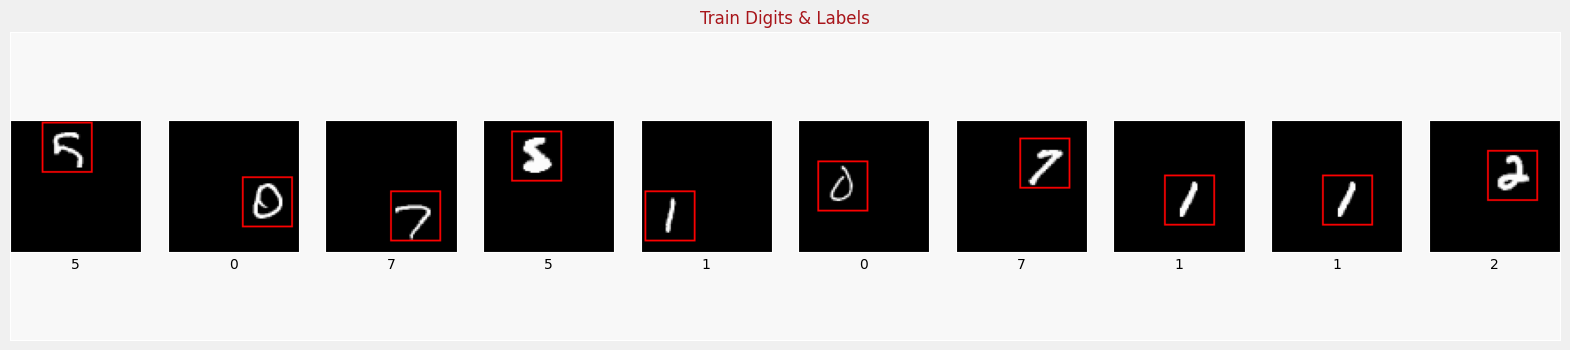

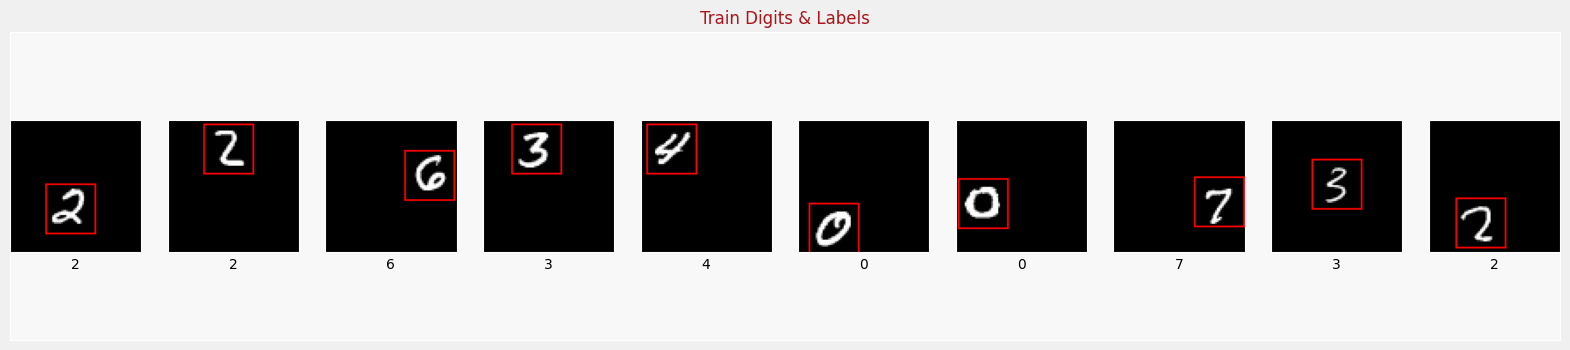

In [45]:
display_digits_with_boxes(train_digits, train_labels, train_labels, np.array([]), train_bboxes, np.array([]), TITLE_TRAIN_DIGIT_DISPLAY)
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, np.array([]), validation_bboxes, np.array([]), TITLE_TRAIN_DIGIT_DISPLAY)